In [ ]:
import copy
from   random import choice
import math 

import numpy as np
from   sklearn.cluster import HDBSCAN, DBSCAN
import hdbscan

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import NaiveDE
import SpatialDE
import pandas as pd

import networkx as nx

from plot import *
from data import *
from filt import *
from filt import ITNI, ITSNI, VNI

In [24]:
W = '#efefd0'
B = '#004e89'
mpl.rcParams['text.color']       = B
mpl.rcParams['axes.labelcolor']  = W
mpl.rcParams['axes.edgecolor']   = W
mpl.rcParams['axes.facecolor']   = W
mpl.rcParams['figure.facecolor'] = W
mpl.rcParams['xtick.color']      = W
mpl.rcParams['ytick.color']      = W
mpl.rcParams['font.family']      = "monospace"


Or = "#ff6b35"
colors    = [B, Or]
cmap_name = "balck_yellow"
myCMAP    = LinearSegmentedColormap.from_list(cmap_name, colors)


In [127]:
scdata     = load_data()
array_data = scdata.X.toarray().T

### map from index of spot to cartesian coordinates
index_to_cart = np.zeros((len(scdata.obs), 2))
max_row       = scdata.obs['array_row'].max()
for i, ind in enumerate(scdata.obs.index):
    col = scdata.obs['array_col'][ind]
    row = scdata.obs['array_row'][ind]
    index_to_cart[i, 0] = col             * (np.sqrt(3)/2)
    index_to_cart[i, 1] = (max_row - row) * (3/2)

# smallest = select_top_spatially_variable_genes(scdata, 3000, 1000, 3000)
# print(smallest.shape)

smallest = np.load("spatially_variable_genes.npy")
print(smallest.shape)

array_data = array_data[smallest]

c:\Users\Workstation\magistrale\algo_ai\Lib\site-packages\anndata\_core\anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\Workstation\magistrale\algo_ai\Lib\site-packages\anndata\_core\anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


(3558,)


In [133]:
# before calculate neighbour similarity apply filter to all data
for i in range(len(smallest)):
    array_data[i] = opt_mean_filter_iterated(array_data[i], 5)

data_neigh = array_data[:, ITSNI]
data_spot  = array_data

In [134]:
# calculate closest neighbour in eucledian distance
neigh_eucledian_dist = np.sqrt(((data_neigh.T - data_spot.T)**2).sum(axis=2))
best_neigh_eucl      = np.argmin(neigh_eucledian_dist, axis=0)
worst_neigh_eucl     = np.argmax(neigh_eucledian_dist, axis=0)
arange               = np.arange(len(best_neigh_eucl))
best_neigh_eucl_idx  = ITSNI[arange, best_neigh_eucl]
worst_neigh_eucl_idx = ITSNI[arange, worst_neigh_eucl]

# calculate closest neighbour in cosine distance
num                 = (data_neigh.T * data_spot.T).sum(axis=2)
den                 = ((data_neigh**2).sum(axis=0)*(data_spot**2).sum(axis=0).reshape((-1, 1)))
neigh_cos_sim       = num.T / den
best_neigh_cos      = np.argmax(neigh_cos_sim, axis=1)
worst_neigh_cos     = np.argmin(neigh_cos_sim, axis=1)
best_neigh_cos_idx  = ITSNI[arange, best_neigh_cos]
worst_neigh_cos_idx = ITSNI[arange, worst_neigh_cos]

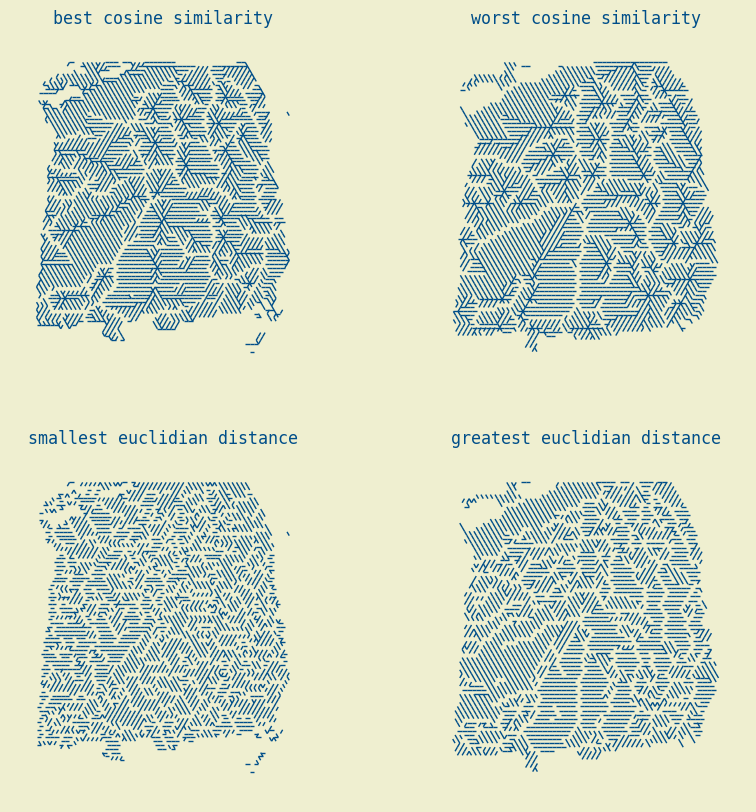

In [140]:
NSpot = len(array_data[0])
pos   = {i:index_to_cart[i] for i in range(NSpot)}

_, axs = plt.subplots(2, 2, figsize=(10, 10))

titles = ["best cosine similarity", 
          "worst cosine similarity", 
          "smallest euclidian distance", 
          "greatest euclidian distance"]

for i, neigh_idx in enumerate([
                        best_neigh_cos_idx, 
                        worst_neigh_cos_idx, 
                        best_neigh_eucl_idx, 
                        worst_neigh_eucl_idx]):

    ax = axs[i//2][i%2]
    BNAM = np.zeros((NSpot, NSpot), dtype=int)
    for n in range(NSpot):
        if neigh_idx[n] != -1:
            BNAM[n, neigh_idx[n]] = 1

    g = nx.Graph(BNAM)
    nx.draw_networkx_edges(g, pos, width=1, edge_color=B, alpha=1, ax=ax)
    # nx.draw_networkx_nodes(g, pos, node_size=0.1, node_color=B, alpha=1, ax=ax)
    ax.set_title(titles[i])
    ax.set_aspect("equal")
plt.savefig("presentazione\\edge_graphs", dpi=1000)
plt.show()

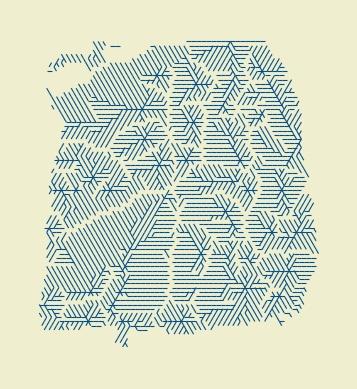

In [177]:
NTOP = 1
# calculate closest neighbour in eucledian distance
neigh_eucledian_dist = np.sqrt(((data_neigh.T - data_spot.T)**2).sum(axis=2))
neigh_eculedian_sort = np.argsort(neigh_eucledian_dist, axis=0)
best_neigh_eucl      = neigh_eculedian_sort[:NTOP]
worst_neigh_eucl     = neigh_eculedian_sort[-NTOP:]
arange               = np.arange(len(best_neigh_eucl[0]))
best_neigh_eucl_idx  = ITSNI[arange, best_neigh_eucl]
worst_neigh_eucl_idx = ITSNI[arange, worst_neigh_eucl]

# calculate closest neighbour in cosine distance
num                 = (data_neigh.T * data_spot.T).sum(axis=2)
den                 = ((data_neigh**2).sum(axis=0)*(data_spot**2).sum(axis=0).reshape((-1, 1)))
neigh_cos_sim       = num.T / den
neigh_cos_sim_sort  = np.argsort(neigh_cos_sim, axis=1)
best_neigh_cos      = neigh_cos_sim_sort[:, -NTOP:]
worst_neigh_cos     = neigh_cos_sim_sort[:, :NTOP]
best_neigh_cos_idx  = ITSNI[arange, best_neigh_cos.T]
worst_neigh_cos_idx = ITSNI[arange, worst_neigh_cos.T]

neigh_idx = best_neigh_cos_idx.T
AM1 = np.zeros((NSpot, NSpot), dtype=int)
for i in range(NSpot):
    valid_neighbours = list(filter(lambda x: x != -1, neigh_idx[i]))
    AM1[i, valid_neighbours] = 1

neigh_idx = worst_neigh_cos_idx.T
AM2 = np.zeros((NSpot, NSpot), dtype=int)
for i in range(NSpot):
    valid_neighbours = list(filter(lambda x: x != -1, neigh_idx[i]))
    AM2[i, valid_neighbours] = 1

AM = AM2

g = nx.Graph(AM2)
nx.draw_networkx_edges(g, pos, width=0.8, edge_color=B, alpha=1)
# g = nx.Graph(AM1)
# nx.draw_networkx_edges(g, pos, width=0.8, edge_color=Or, alpha=1)
# nx.draw_networkx_nodes(g, pos, node_size=1, node_color=B, alpha=1)
plt.gca().set_aspect("equal")
#plt.savefig("something", dpi=1000)

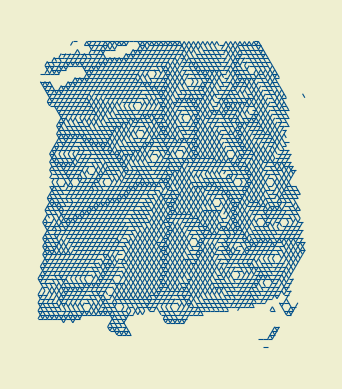

In [35]:
nAM = np.zeros((NSpot, NSpot), dtype=int)
for i in range(NSpot):
    neighs = list(filter(lambda x: x!=-1, ITSNI[i]))
    for n in neighs:
        if AM[i, n] == 0 and AM[n, i] == 0:
            nAM[i, n] = 1

g = nx.Graph(nAM)
nx.draw_networkx_edges(g, pos, width=0.8,     edge_color=B, alpha=1)
# nx.draw_networkx_nodes(g, pos, node_size=1, node_color=B, alpha=1)
plt.gca().set_aspect("equal")

In [64]:
def in_community(i, communities):
    for k, v in communities.items():
        if i in v:
            return True
    return False

communities = dict()
communities[0] = []

AM = AM + AM.T
AM[AM > 1] = 1

c = 1
for i in range(NSpot):
    if in_community(i, communities):
        continue
    community = [i]
    todo = [i]
    while len(todo) > 0:
        n  = todo.pop()
        nn = np.where(AM[n] == 1)[0]
        if len(nn) == 0:
            continue
        for nni in nn:
            if nni not in community:
                community.append(nni)
                todo.append(nni)
        
    if len(community) > 10:
        communities[c] = community
        c += 1
    else:
        communities[0] += community

In [66]:
labels = np.zeros((NSpot), dtype=int)
for k, v in communities.items():
    for n in v:
        labels[v] = k

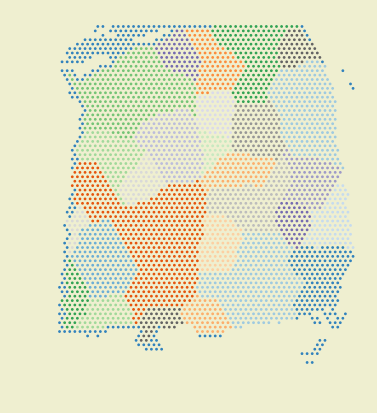

In [73]:
plt.scatter(index_to_cart[:, 0], index_to_cart[:, 1], cmap="tab20c", s=1, c=labels)

plt.gca().set_aspect("equal")

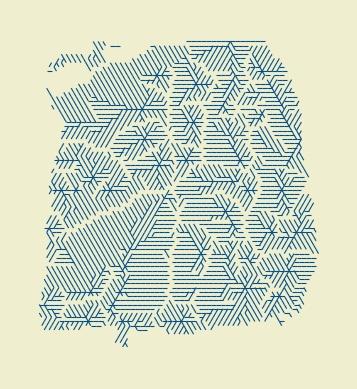

In [142]:
g = nx.Graph(AM)

#nx.draw_networkx_nodes(g, pos, node_size=1, cmap="Dark2",node_color=labels, alpha=1)
plt.gca().set_aspect("equal")

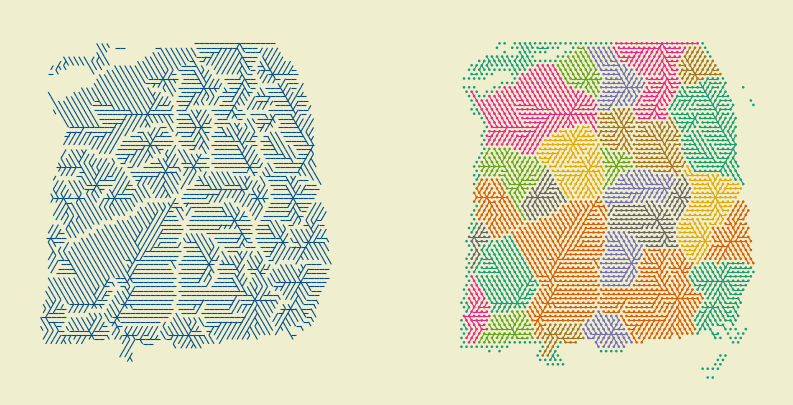

In [ ]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5)) 

edgelist    = []
edge_colors = []
for i in range(NSpot):
    row = AM[i]
    c = labels[i]
    for n in np.where(row == 1)[0]:
        edgelist.append((i, n))
        edge_colors.append(c)

g = nx.Graph(AM)

nx.draw_networkx_edges(
    g, 
    pos, 
    edgelist   = edgelist,
    width      = 0.8, 
    edge_cmap  = mpl.colormaps.get("Dark2"), 
    edge_color = edge_colors, 
    alpha      = 1,
    ax         = ax2)
ax1.set_aspect("equal")


nx.draw_networkx_edges(g, pos, width=0.8,   edge_color=B, alpha=1, ax=ax1)
ax2.set_aspect("equal")

# plt.savefig("presentazione\\graphs_worst_cos_cluster", dpi=1000)

nx.draw_networkx_nodes(g, pos, ax=ax2, node_shape="h", node_size=1, cmap="Dark2",node_color=labels, alpha=1)


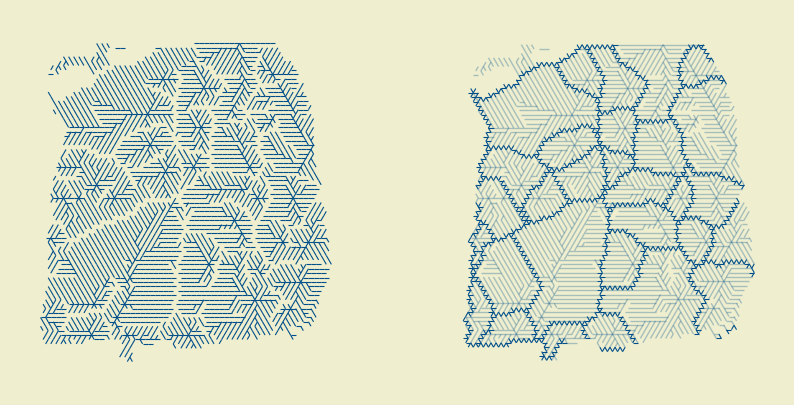

In [175]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5)) 


g = nx.Graph(AM)
nx.draw_networkx_edges(g, pos, width=0.8,   edge_color=B, alpha=1, ax=ax1)
ax1.set_aspect("equal")


nAM = np.zeros((NSpot, NSpot), dtype=int)
for i in range(NSpot):
    neighs = list(filter(lambda x: x!=-1, ITSNI[i]))
    for n in neighs:
        if labels[i] != labels[n]:
            nAM[i, n] = 1

nx.draw_networkx_edges(g, pos, width=1, edge_color=B, alpha=0.3, ax=ax2)

g = nx.Graph(nAM)
nx.draw_networkx_edges(g, pos, width=0.8, edge_color=B, alpha=1, ax=ax2)

ax2.set_aspect("equal")
plt.savefig("presentazione\\graphs_worst_cos_border", dpi=1000)


In [178]:
transformed_gdata = np.load("trasnformed_gdata.npy")

In [180]:
data_neigh = transformed_gdata[:, ITSNI]
data_spot  = transformed_gdata

In [230]:
NTOP = 2
# calculate closest neighbour in eucledian distance
neigh_jaccard_dist = ((data_neigh.T & data_spot.T).sum(-1) / (data_neigh.T | data_spot.T).sum(-1)).T
neigh_jaccard_sort = np.argsort(neigh_jaccard_dist, axis=1)

best_neigh_jaccard      = neigh_jaccard_sort[:, :NTOP]
worst_neigh_jaccard     = neigh_jaccard_sort[:, -NTOP:]

arange                  = np.arange(len(best_neigh_jaccard))
best_neigh_jaccard_idx  = ITSNI[arange, best_neigh_jaccard.T]
worst_neigh_jaccard_idx = ITSNI[arange, worst_neigh_jaccard.T]

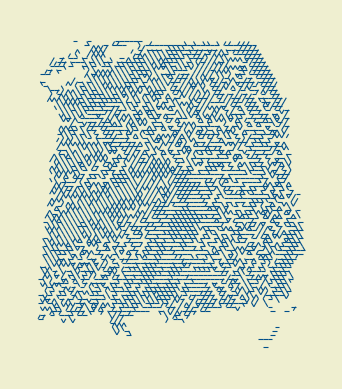

In [231]:
neigh_idx = best_neigh_jaccard_idx.T
AM = np.zeros((NSpot, NSpot), dtype=int)
for i in range(NSpot):
    valid_neighbours = list(filter(lambda x: x != -1, neigh_idx[i]))
    AM[i, valid_neighbours] = 1

g = nx.Graph(AM)
nx.draw_networkx_edges(g, pos, width=0.8, edge_color=B, alpha=1)
plt.gca().set_aspect("equal")

In [247]:
NTOP = 2
# calculate closest neighbour in cosine distance
num                 = (data_neigh.T * data_spot.T).sum(axis=2)
den                 = ((data_neigh**2).sum(axis=0)*(data_spot**2).sum(axis=0).reshape((-1, 1)))
neigh_cos_sim       = num.T / den
neigh_cos_sim_sort  = np.argsort(neigh_cos_sim, axis=1)
best_neigh_cos      = neigh_cos_sim_sort[:, -NTOP:]
worst_neigh_cos     = neigh_cos_sim_sort[:, :NTOP]
arange              = np.arange(len(best_neigh_cos))
best_neigh_cos_idx  = ITSNI[arange, best_neigh_cos.T]
worst_neigh_cos_idx = ITSNI[arange, worst_neigh_cos.T]


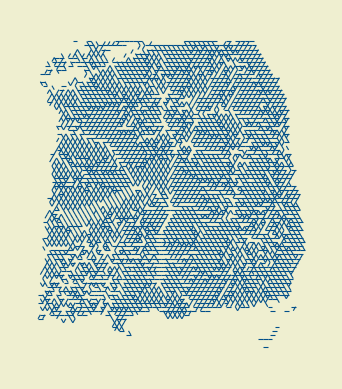

In [248]:
neigh_idx = worst_neigh_cos_idx.T
AM = np.zeros((NSpot, NSpot), dtype=int)
for i in range(NSpot):
    valid_neighbours = list(filter(lambda x: x != -1, neigh_idx[i]))
    AM[i, valid_neighbours] = 1

g = nx.Graph(AM)
nx.draw_networkx_edges(g, pos, width=0.8, edge_color=B, alpha=1)
plt.gca().set_aspect("equal")